In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14


# ガウス過程回帰の適用・予測の実施
def fit_and_predict(x, y, var, alpha, beta):
    num_data = len(x)
    kernel_arr = np.zeros((num_data, num_data))
    for i in range(num_data):
        for j in range(num_data):
            kernel_arr[i, j] = gaussian_kernel(x[i], x[j], var)

    c_matrix = 1/alpha*kernel_arr + 1/beta*np.eye(num_data)
    c_matrix_inv = np.linalg.inv(c_matrix)

    res = []
    x_star_list = [i/10 for i in range(-70, 71)]
    for x_star in x_star_list:
        c_vector, c_scalar = calc_c(x_star, alpha, var, num_data)
        tmp = np.dot(c_vector.T, c_matrix_inv)
        mean = np.dot(tmp, y)
        std = np.sqrt(c_scalar - np.dot(tmp, c_vector))
        res += [
            {
                "x_star": x_star,
                "mean": mean,
                "upper_1sd": mean + std,
                "lower_1sd": mean - std,
            }
        ]
    return pd.DataFrame(res)


def gaussian_kernel(x, x_prime, var):
    return np.exp(-1/(2*var)*((x-x_prime)**2))


def calc_c(x_star, alpha, var, num_data):
    c_vector = 1/alpha*np.array([gaussian_kernel(x[i], x_star, var) for i in range(num_data)])
    c_scalar = 1/alpha*gaussian_kernel(x_star, x_star, var) + 1/beta
    return c_vector, c_scalar


def show_results(x, y, res_df):
    x_star = res_df["x_star"].values

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y, marker='o', label="observed data", color="r", edgecolor="k")
    plt.plot(x_star, res_df["mean"].values, label="inferred function", color="k")
    plt.plot(x_star, res_df["upper_1sd"].values, label="+1 S.D.", color="gray", linestyle="dashed")
    plt.plot(x_star, res_df["lower_1sd"].values, label="-1 S.D.", color="gray", linestyle="dashed")
    plt.ylim(-4, 4)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid()
    plt.show()

**予測分布**
$$
\begin{aligned}
p\left(y^{(*)} \mid \mathbf{y}\right) &=\mathcal{N}\left(y^{(*)} ; \mathbf{c}^{\top} \mathbf{C}^{-1} \mathbf{y}, c-\mathbf{c}^{\top} \mathbf{C}^{-1} \mathbf{c}\right) \\
\mathbf{C} &:=\alpha^{-1}\left[\begin{array}{ccc}
k\left(\mathbf{x}^{(1)}, \mathbf{x}^{(1)}\right) & \ldots & k\left(\mathbf{x}^{(1)}, \mathbf{x}^{(N)}\right) \\
\vdots & \ddots & \vdots \\
k\left(\mathbf{x}^{(N)}, \mathbf{x}^{(1)}\right) & \ldots & k\left(\mathbf{x}^{(N)}, \mathbf{x}^{(N)}\right)
\end{array}\right]+\beta^{-1} \mathbf{I}_{N \times N} \\
\mathbf{c} &:=\alpha^{-1}\left[\begin{array}{c}
k\left(\mathbf{x}^{(1)}, \mathbf{x}^{(*)}\right) \\
\vdots \\
k\left(\mathbf{x}^{(N)}, \mathbf{x}^{(*)}\right)
\end{array}\right] \\
c &:=\alpha^{-1} k\left(\mathbf{x}^{(*)}, \mathbf{x}^{(*)}\right)+\beta^{-1}
\end{aligned}
$$

**ガウシアンカーネル**
$$
k\left(\mathbf{x}, \mathbf{x}^{\prime}\right):=\exp \left(-\frac{1}{2 \sigma^{2}}\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|_{2}^{2}\right)
$$

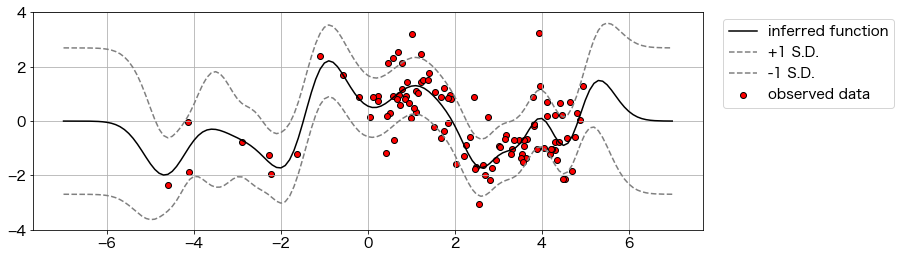

In [2]:
df = pd.read_table("data/GaussianProcessData20121209.txt", names=["x", "y"])
x = df["x"].values
y = df["y"].values

# パラメータ
var = 0.25
alpha = 0.16
beta = 1.0

res_df = fit_and_predict(x, y, var, alpha, beta)
show_results(x, y, res_df)

**考察**

観測データが多い箇所ほど±1S.D.の範囲が狭く, 逆に少ないとこは広くなっている. これは新しい点 $x^{(*)}$ と観測点 $x^{(1)}$~$x^{(N)}$ をカーネル関数に通した時に, 観測点が周りに少ないと推定される分散が大きくなる (ベクトル $\mathbf{c}$ の各要素の値が小さくなる) 影響であり, その違いが $x=-3.5$ 付近で顕著に出ている.